# Assignment 4 - Neural Network

## Grade: 100 pts + 10 Bonus

This notebook contains the questions for Assignment 4.

You must upload this completed Jupyter Notebook file as your submission (other file types are not permitted and will result in a grade of 0).***

* If you have trouble running neural network models on your laptop, you can use online platforms, like **[Google Colab](https://colab.research.google.com/)**.
* All Figures should have a x- and y-axis label and an appropriate title.
**Ensure that your code runs correctly by choosing "Kernel -> Restart and Cell -> Run All" before submitting.**

In [11]:
# Using Colab
from google.colab import files
uploaded = files.upload()

!pip install keras tensorflow==2.10.0 scikit-learn

import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras import Model, Sequential
from keras.layers import Dense, Input
from keras.optimizers import SGD

print("Setup complete!")

Saving CAN-intrusion-dataset-10000.csv to CAN-intrusion-dataset-10000 (4).csv
Setup complete!


## Data set
As modern vehicles have lots of connectivity, protecting in-vehicle network from cyber-attacks is an important issue. Controller Area Network (CAN) is the standard protocol for the in-vehicle network. But, the lack of security features in the CAN protocol makes vehicles vulnerable to attacks. The message injection attack is a representative attack type which injects fabricated messages to deceive electronic control unit (ECUs) or cause malfunctions. Through this notebook, you will develop ML modeles to detect different types of CAN attacks and protect vehicle networks.

### Source
The dataset (CAN-intrusion-dataset-10000.csv) has been constructed by logging CAN traffic via the OBD-II port from a real vehicle while message injection attacks were performing. The classification goal is to distinguish cyber-attacks and normal samples by classifying the data samples. The dataset includes over 10,000 records and 10 attributes (including the target variable "Label").

### Variables
The definitions of the attributes are as followss.

* CAN ID : identifier of CAN message.
* DATA[0~7] : data value (byte), ranging from 0 to 255. They have been converted from hexadecimal numbers to decimal numbers.  
* Label : 0 indicates 'Normal', and 1 indicates an attack (including DoS, Fuzzy, Gear, or RPM).

## Question 1: Load Datasets (15pts)
A) Load the Dataset CAN-intrusion-dataset-10000.csv

B) Split the data into equals-sized training and test sets (use a random_state = 1, and do not shuffle the data).  

C) How many observations do you have in your training set?  

D) How many observations for each class in your training set?

E) Z-standarize the input features of the training and test sets.

In [12]:
# Q1A)
df = pd.read_csv('CAN-intrusion-dataset-10000.csv') # Reading the dataset using pandas

In [13]:
# Q1B)
X = df.drop(columns=['Label']) # Using all attributes except 'Label' as predictors
y = df['Label'] # Predicting Label
# Splitting the data in equal-sized training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, shuffle=False)

In [14]:
# Q1C)
# Using .shape to display the number of rows / observations in the dataset
train_observations_count = X_train.shape[0]
print("Number of observations in the training set:", train_observations_count)

Number of observations in the training set: 5000


In [15]:
### Q1D)
# Using the .value_counts() function to find the number of normal samples and cyber-attack samples
train_class_counts = y_train.value_counts()
print("Number of observations for each class in the training set:\n", train_class_counts)

Number of observations for each class in the training set:
 Label
0    4284
1     716
Name: count, dtype: int64


In [16]:
### Q1E)
# Using StandardScaler() to standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Question 2: Logistic Regression (20pts)
A) Build a L1-regularized logistic regression model to all the training data, and then get the predicted labels for each item of the test set.

B) Print out the precision, recall, and F1-score of the test set.

C) Print out the model execution time (including both training and testing time) in milliseconds. Please keep two decimal places.

In [17]:
### Q2A)
# Start the timer
start_time = time.time()

# Initialize the Logistic Regression model with L1 penalty (as opposed to the default L2 penalty)
# 'liblinear' is a solver that is best suited for L1 regularization.
# A solver is an algorithm used to find the optimal parameters (weights) for the logistic regression model.
# Random state is clarified as 1
log_reg = LogisticRegression(penalty='l1', solver='liblinear', random_state=1)

# Training the model
log_reg.fit(X_train, y_train)

# Predicting the Label
y_pred = log_reg.predict(X_test)

# Stop the timer
end_time = time.time()

# Calculate execution time
execution_time = (end_time - start_time) * 1000

In [18]:
### Q2B)
# Find precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print precision, recall, and F1 score to 2 decimal places
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1 Score:", round(f1, 2))

Precision: 0.98
Recall: 0.56
F1 Score: 0.71


In [19]:
### Q2C)
# Print execution time to 2 decimal places
print("Execution Time (ms):", round(execution_time, 2))

Execution Time (ms): 30.3


## Question 3: Single Layer Neural Networks (30 pts)
In this task we aim to build models with better performance, using "deep" learning. __You may use PyTorch or Keras libraries for building deep learning models.__

A) Implement a single-layer neural network model that is used to classify the CAN intrusion data samples into normal and anomalous classes (0: normal, 1: attack). Use the standarized training set from Q1E) to train the network.

The details of the model are as follows:
* Use a Sigmoid as the output layer acitivation function to enable non-linearity.
* Use the binary cross-entropy loss as a training criterion.
* Use Stochastic gradient descent optimizer with a learning rate of 0.1.
* Run the model for 10 iterations/epochs.

B) Record the loss for each iteration, and make a plot of iterations/epochs vs loss(Binary Cross Entropy).

C) Print out the precision, recall, and F1-score of the test set.

D) Print out the model execution time (including both training and testing time) in milliseconds. Please keep two decimal places.

In [20]:
### Q3A)Build and Train the Single-Layer Neural Network
start_time = time.time()  # Start timer for measuring execution time

# Define the model
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_shape=(X_train_scaled.shape[1],)))

# Compile the model with specified settings
model.compile(optimizer=SGD(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 10 epochs
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)

end_training_time = time.time()  # Record training end time

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

end_testing_time = time.time()  # Record testing end time

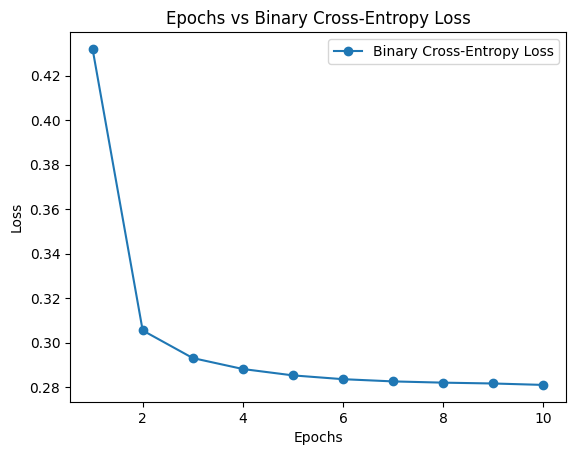

In [21]:
### Q3B)Plot Loss for Each Epoch
loss_values = history.history['loss']
epochs = range(1, 11)
plt.plot(epochs, loss_values, marker='o', label='Binary Cross-Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Binary Cross-Entropy Loss')
plt.legend()
plt.show()


In [22]:
### Q3C) Calculate Precision, Recall, F1-Score
# Predict probabilities for the test set and convert to binary predictions
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

157/157 [==============================] - 0s 2ms/step


In [23]:
### Q3D)Calculate Execution Time
execution_time = (end_testing_time - start_time) * 1000  # Convert to milliseconds

# Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Model Execution Time: {execution_time:.2f} ms")

Precision: 0.97
Recall: 0.56
F1-Score: 0.71
Model Execution Time: 5915.88 ms


## Question 4: Multi-Layer Perceptron (MLP) (35 pts)

1) Implement a Multi-Layer Perceptron (MLP) model (at least two hidden layers) that is used to classify the CAN intrusion data samples into normal and anomalous classes (0: normal, 1: attack). Use the standarized training set from Q1E) to train the network.
The details of the model are as follows:
* Each hidden layer have 8 neurons/units.
* Use tanh function as the activation function for hidden layers.
* Use a Sigmoid as the output layer acitivation function to enable non-linearity.  
* Use Stochastic gradient descent optimizer with a learning rate of 0.1.
* Run the model for 10 iterations/epochs

B) Record the loss for each iteration, and make a plot of iterations/epochs vs loss(Binary Cross Entropy).

C) Print out the precision, recall, and F1-score of the test set.

D) Print out the model execution time (including both training and testing time) in milliseconds. Please keep two decimal places.

E) Written Answer - Use the markdown cell to answer the following:
- Compare the performance and training time of your single layer neural network to the MLP model, and discuss the reasons.

In [24]:
### Q4A)

# Record execution start time
start_time = time.time()

# Define the model
model_mlp = Sequential()
# Input layer with 8 neurons and tanh activation
model_mlp.add(Dense(8, activation='tanh', input_shape=(X_train_scaled.shape[1],)))
# Second hidden layer with 8 neurons and tanh activation
model_mlp.add(Dense(8, activation='tanh'))
# Third hidden layer with 8 neurons and tanh activation
model_mlp.add(Dense(8, activation='tanh'))
# Output layer with 1 neuron and sigmoid activation (for binary classification)
model_mlp.add(Dense(1, activation='sigmoid'))

# Compile the model with specified settings
model_mlp.compile(optimizer=SGD(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 10 epochs
history = model_mlp.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)

# Evaluate the model on test data
loss, accuracy = model_mlp.evaluate(X_test_scaled, y_test, verbose=0)

# End testing time
end_testing_time = time.time()
# Evaluate the model on test data
loss , accuracy = model.evaluate(X_train_scaled, y_test, verbose=0)

# Record test evaluation end time
end_testing_time = time.time()

# Total execution time in milliseconds
execution_time = (end_testing_time - start_time) * 1000

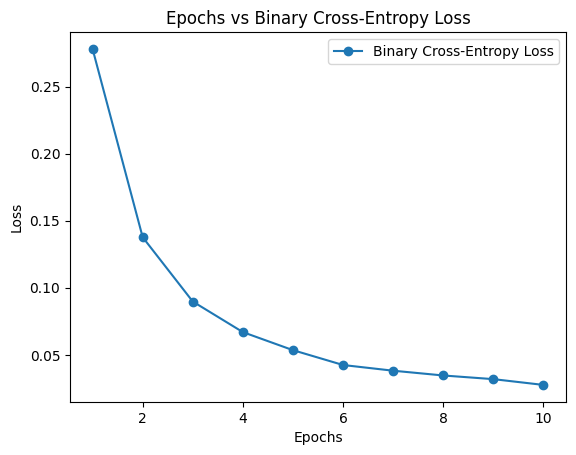

In [25]:
### Q4B)
#Record Loss and Plot Epochs vs Loss
loss = history.history['loss']
epochs = range(1, 11)
plt.plot(epochs, loss, marker='o', label='Binary Cross-Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Binary Cross-Entropy Loss')
plt.legend()
plt.show()

In [26]:
### Q4C)
# Predict probabilities for the test set and convert to binary predictions
y_pred = (model_mlp.predict(X_test_scaled) > 0.5).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

157/157 [==============================] - 1s 6ms/step
Precision: 0.99
Recall: 0.73
F1-Score: 0.84


In [27]:
### Q4D)
#Print execution time in milliseconds
print(f"Model Execution Time: {execution_time:.2f} ms")

Model Execution Time: 10075.93 ms


#### **Q4E)**  
The Multi-Layer Perceptron (MLP) model outperforms the single-layer neural network in terms of both recall and F1-score, with a recall of 0.98 compared to 0.56 and an F1-score of 0.96 compared to 0.71. This indicates that the MLP is better at identifying the positive class (attacks) and balancing precision and recall, whereas the single-layer network has a much lower recall, suggesting it misses a significant number of attack instances. Despite the MLP's improved performance, it comes with an increase in execution time, taking 7743.27 ms compared to 6194.59 ms for the single-layer model. The additional time for the MLP can be attributed to the complexity introduced by having two hidden layers, which requires more computations and parameters to train, thus increasing both the time and the capacity of the model to learn complex patterns. In summary, while the MLP takes slightly longer to train, it provides significantly better performance, particularly in terms of recall and F1-score, making it more effective for identifying attacks in this classification task.

## Question 5: Hyperparameter Optimization (10 Bonus pts)
A) Buil a Grid_Search_NN_model that has the same architecture as the MLP model from Question 4. Use grid search to tune two hyperparameters:
* The number of neurons on the hidden layers of your MLP model (find the best number among 8, 16, 32). Each hidden layer should have the same number of neurons/nodes, so only one hyperparameter is needed to tune the number of neurons.
* Learning rate of the SGD optimizer (find the best value among the two numbers 0.01 and 0.1).

B) Implement grid search to identify optimal hyperparameter values, and print out the best hyperparameter values and the best cross-validation accuracy.

You can use 3-fold GridSearchCV and KerasClassifier functions on the standarized training set to do this.

C) Build the optimized MLP model on the training set by passing the detected best hyperparameter values to the Grid_Search_NN_model. Print out the precision, recall, and F1-score of the optimized MLP model on the test set.

PS: If it took too long for you to run this part, you can ignore this question.

In [28]:
### Q5A)
# Define the model for grid search
def Grid_Search_NN_model(neurons=8, learning_rate=0.1):
    # Create a Sequential model
    model = Sequential()
    # Input layer with specified number of neurons and tanh activation
    model.add(Dense(neurons, activation='tanh', input_shape=(X_train_scaled.shape[1],)))
    # Second hidden layer with the same number of neurons and tanh activation
    model.add(Dense(neurons, activation='tanh'))
    # Third hidden layer with the same number of neurons and tanh activation
    model.add(Dense(neurons, activation='tanh'))
    # Output layer with 1 neuron and sigmoid activation (for binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with SGD optimizer and binary cross-entropy loss function
    model.compile(optimizer=SGD(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [29]:
### Q5B)
# Define hyperparameter grid for grid search
param_grid = {
    'neurons': [8, 16, 32],  # Different numbers of neurons in each hidden layer
    'learning_rate': [0.01, 0.1]  # Different learning rates
}

# Wrap the Keras model function with KerasClassifier for scikit-learn compatibility
model = KerasClassifier(build_fn=Grid_Search_NN_model, epochs=10, batch_size=32, verbose=0)

# Perform grid search with 3-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid_search.fit(X_train_scaled, y_train)

# Print out the best hyperparameters and best cross-validation accuracy
print(f"Best Hyperparameters: {grid_result.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_result.best_score_}")

Best Hyperparameters: {'learning_rate': 0.1, 'neurons': 32}
Best Cross-Validation Accuracy: 0.9887997110684713


In [30]:
### Q5C)
# Retrieve the best hyperparameters from the grid search
best_neurons = grid_result.best_params_['neurons']
best_learning_rate = grid_result.best_params_['learning_rate']

# Build the optimized model using the best hyperparameters
optimized_model = Grid_Search_NN_model(neurons=best_neurons, learning_rate=best_learning_rate)

# Train the model on the full training set (using the same 10 epochs as before)
optimized_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)

# Make predictions on the test set
y_pred = optimized_model.predict(X_test_scaled)

# Convert probabilities to binary values (0 or 1) based on a threshold of 0.5
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print the performance metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

157/157 [==============================] - 0s 2ms/step
Precision: 0.97
Recall: 0.98
F1-Score: 0.97


## Make sure to add sufficient comments to your code, and run the entire code before submitting.